# NLP Model for Hate Speech Classification

## Dev's Profile

Nama : Tariq Fitria Aziz <br>
Bergabung: 02 September 2020 <br>
Asal: Kabupaten Wonogiri, Jawa Tengah

## Problem Desc

Di sini, akan dibuat sebuah model Natural Language Processing (NLP) yang dapat digunakan untuk mengklasifikasikan tweet tentang Coronavirus, berdasarkan sentimennya. <br>

Dataset yang digunakan dapat dilihat di sumber berikut: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

## Part I: Preparation

### Import Library

In [1]:
from google.colab import drive
import chardet
import string

import nltk
import spacy
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Set Drive Folder

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


## Part II: Data Preparation

### Data Loading

In [4]:
data_train = pd.read_csv('/content/drive/MyDrive/Datasets/Corona_NLP_train.csv', encoding='latin-1')
data_train.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
data_test = pd.read_csv('/content/drive/MyDrive/Datasets/Corona_NLP_test.csv', encoding='latin-1')
data_test.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


### Data Information

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


### Data Preprocessing

Drop Unneeded Labels

In [8]:
columns = ['UserName', 'ScreenName', 'Location', 'TweetAt']
data_train2 = data_train.drop(columns = columns)

In [9]:
data_test2 = data_test.drop(columns = columns)

Change Labels Value

In [10]:
data_train2['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [11]:
data_train2['Sentiment'] = data_train2['Sentiment'].replace('Extremely Positive', 'Positive')
data_train2['Sentiment'] = data_train2['Sentiment'].replace('Extremely Negative', 'Negative')

In [12]:
data_train2['Sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [13]:
data_test2['Sentiment'] = data_test2['Sentiment'].replace('Extremely Positive', 'Positive')
data_test2['Sentiment'] = data_test2['Sentiment'].replace('Extremely Negative', 'Negative')

In [14]:
data_test2['Sentiment'].unique()

array(['Negative', 'Positive', 'Neutral'], dtype=object)

One-Hot-Encoding

In [15]:
cat = pd.get_dummies(data_train2['Sentiment'])
data_train3 = pd.concat([data_train2, cat], axis=1)
data_train3 = data_train3.drop(columns='Sentiment')
data_train3.head(10)

,OriginalTweet,Negative,Neutral,Positive
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,1,0
1,advice Talk to your neighbours family to excha...,0,0,1
2,Coronavirus Australia: Woolworths to give elde...,0,0,1
3,My food stock is not the only one which is emp...,0,0,1
4,"Me, ready to go at supermarket during the #COV...",1,0,0
5,As news of the regionÂs first confirmed COVID...,0,0,1
6,Cashier at grocery store was sharing his insig...,0,0,1
7,Was at the supermarket today. Didn't buy toile...,0,1,0
8,Due to COVID-19 our retail store and classroom...,0,0,1
9,"For corona prevention,we should stop to buy th...",1,0,0


In [16]:
cat2 = pd.get_dummies(data_test2['Sentiment'])
data_test3 = pd.concat([data_test2, cat2], axis=1)
data_test3 = data_test3.drop(columns='Sentiment')
data_test3.head(10)

,OriginalTweet,Negative,Neutral,Positive
0,TRENDING: New Yorkers encounter empty supermar...,1,0,0
1,When I couldn't find hand sanitizer at Fred Me...,0,0,1
2,Find out how you can protect yourself and love...,0,0,1
3,#Panic buying hits #NewYork City as anxious sh...,1,0,0
4,#toiletpaper #dunnypaper #coronavirus #coronav...,0,1,0
5,Do you remember the last time you paid $2.99 a...,0,1,0
6,Voting in the age of #coronavirus = hand sanit...,0,0,1
7,"@DrTedros ""We canÂt stop #COVID19 without pro...",0,1,0
8,HI TWITTER! I am a pharmacist. I sell hand san...,1,0,0
9,Anyone been in a supermarket over the last few...,0,0,1


### Data Split

In [35]:
text0 = data_train3['OriginalTweet'].values
labels0 = data_train3.iloc[:, 1:].values

In [36]:
text_latih, text_valid, labels_latih, labels_valid = train_test_split(text0, labels0, test_size = 0.13)

In [37]:
text_valid2 = data_test3['OriginalTweet'].values
labels_valid2 = data_test3.iloc[:, 1:].values

In [38]:
text_valid = np.concatenate((text_valid, text_valid2), axis = 0)

In [39]:
labels_valid = np.concatenate((labels_valid, labels_valid2), axis = 0)

In [40]:
text_valid.shape

(9149,)

In [41]:
text_latih.shape

(35806,)

## Part III: Text Preprocessing

### Text Cleaning

In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
def clean_text(teks):
  new_teks = []
  teks = teks.tolist()
  for i in teks:
    cleaned = i.lower()

    unknown = ['â\x97', 'â\x96', 'â\x92', 'USER', '\r', '\n', '\\n', '\\xf0', 
               '\\x9f', '\\x98', '\\xaa', 'https://t.co/', '&gt;', '.g']
    for j in unknown:
      cleaned = cleaned.replace(j, '')
    
    for k in range(0,10):
      cleaned = cleaned.replace('{}'.format(k), '')
    
    tanda_baca = ['"','%','&','(',')','*','+',',','-','.',';','<','=','>','[',']',
                  '^','_',',','{','|','}','~','`', '//', '/', ':', '!', '?', '#',
                  '$', '@']
    for l in tanda_baca:
      cleaned = cleaned.replace(l, '')
    
    cleaned = cleaned.strip()
    
    #stopword_list = stopwords.words('english')
    words_in = cleaned.split()
    #for m in stopword_list:
    # words_in = ['' if x == m else x for x in words_in]
    
    alphabet = list(string.ascii_lowercase)
    for n in alphabet:
      words_in = ['' if x == n else x for x in words_in]

    separator = ' '
    cleaned = separator.join(words_in)

    new_teks.append(cleaned)
  
  new_teks = np.array(new_teks)
  return new_teks

In [44]:
text_latih = clean_text(text_latih)
text_valid = clean_text(text_valid)

### Tokenization

In [45]:
tokenizer = Tokenizer(num_words = 5000, oov_token='-', filters='\'')

In [46]:
tokenizer.fit_on_texts(text_latih)
tokenizer.fit_on_texts(text_valid)

In [47]:
tokens = tokenizer.word_index
tokens

{'-': 1,
 'the': 2,
 'to': 3,
 'and': 4,
 'of': 5,
 'covid': 6,
 'in': 7,
 'coronavirus': 8,
 'for': 9,
 'is': 10,
 'are': 11,
 'you': 12,
 'on': 13,
 'at': 14,
 'this': 15,
 'food': 16,
 'prices': 17,
 'store': 18,
 'supermarket': 19,
 'with': 20,
 'that': 21,
 'we': 22,
 'it': 23,
 'grocery': 24,
 'have': 25,
 'as': 26,
 'be': 27,
 'people': 28,
 'from': 29,
 'amp': 30,
 'all': 31,
 'your': 32,
 'not': 33,
 'will': 34,
 'my': 35,
 'consumer': 36,
 'can': 37,
 'they': 38,
 'up': 39,
 'our': 40,
 'or': 41,
 'out': 42,
 'has': 43,
 'shopping': 44,
 'by': 45,
 'more': 46,
 'if': 47,
 's': 48,
 'online': 49,
 'but': 50,
 'how': 51,
 'their': 52,
 'so': 53,
 'during': 54,
 'no': 55,
 'now': 56,
 'about': 57,
 'get': 58,
 'pandemic': 59,
 'what': 60,
 'who': 61,
 'need': 62,
 'just': 63,
 'panic': 64,
 'us': 65,
 't': 66,
 'stock': 67,
 'like': 68,
 'do': 69,
 'was': 70,
 'workers': 71,
 'an': 72,
 'there': 73,
 'go': 74,
 'when': 75,
 'time': 76,
 'some': 77,
 'home': 78,
 'demand': 79,
 '

In [48]:
sekuens_latih = tokenizer.texts_to_sequences(text_latih)
sekuens_valid = tokenizer.texts_to_sequences(text_valid)

### Sequences Padding

In [49]:
padded_sekuens_latih = pad_sequences(sekuens_latih)
padded_sekuens_valid = pad_sequences(sekuens_valid)

## Part IV: Model Creation

### Function Definition

In [50]:
def initialize_model(name, optimizer):
  model = Sequential(name = name)

  model.add(Embedding(
      input_dim=5000, 
      output_dim=32
      )
  )
  model.add(LSTM(
      units = 256,
      dropout = 0.5,
      )
  )
  model.add(Dense(
      units = 512,
      activation = 'relu',
      kernel_initializer = 'he_uniform'
      )
  )
  model.add(Dropout(
      rate = 0.5
      )
  )
  model.add(Dense(
      units = 256,
      activation = 'relu',
      kernel_initializer = 'he_uniform'
      )
  )
  model.add(Dropout(
      rate = 0.5
      )
  )
  model.add(Dense(
      units = 128,
      activation = 'relu',
      kernel_initializer = 'he_uniform'
      )
  )
  model.add(Dropout(
      rate = 0.5
      )
  )
  model.add(Dense(
      units = 3,
      activation = 'softmax',
      )
  )

  model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

  return model

### Model Initialization

In [51]:
Processor1 = initialize_model('Processor1', 'nadam')

### Model Summary

In [52]:
Processor1.summary()

Model: "Processor1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               295936    
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

## Part V: Train Model

### Define Callbacks

In [53]:
es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc1 = ModelCheckpoint('best_model1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

### Train Process

In [54]:
history1 = Processor1.fit(padded_sekuens_latih, labels_latih, epochs = 25, 
                          validation_data=(padded_sekuens_valid, labels_valid), 
                          batch_size = 32, callbacks = [es1, mc1], verbose=1
                          )

Epoch 1/25
1119/1119 [==============================] - 255s 225ms/step - loss: 0.9091 - accuracy: 0.5475 - val_loss: 0.6913 - val_accuracy: 0.7113

Epoch 00001: val_accuracy improved from -inf to 0.71133, saving model to best_model1.h5
Epoch 2/25
1119/1119 [==============================] - 250s 223ms/step - loss: 0.6252 - accuracy: 0.7653 - val_loss: 0.5402 - val_accuracy: 0.8029

Epoch 00002: val_accuracy improved from 0.71133 to 0.80293, saving model to best_model1.h5
Epoch 3/25
1119/1119 [==============================] - 252s 226ms/step - loss: 0.5123 - accuracy: 0.8219 - val_loss: 0.4914 - val_accuracy: 0.8259

Epoch 00003: val_accuracy improved from 0.80293 to 0.82588, saving model to best_model1.h5
Epoch 4/25
1119/1119 [==============================] - 253s 227ms/step - loss: 0.4645 - accuracy: 0.8429 - val_loss: 0.4649 - val_accuracy: 0.8392

Epoch 00004: val_accuracy improved from 0.82588 to 0.83922, saving model to best_model1.h5
Epoch 5/25
1119/1119 [=====================

### Training Results

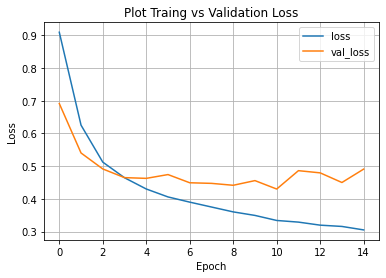

In [55]:
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label='val_loss')

plt.title("Plot Traing vs Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

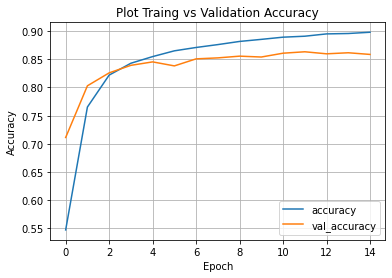

In [56]:
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label='val_accuracy')

plt.title("Plot Traing vs Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()